In [1]:
# %load_ext nb_black

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,scale
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest,chi2
from prettytable import PrettyTable

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc,f1_score,precision_score,recall_score,precision_recall_curve,matthews_corrcoef

### Methods Used

In [2]:
def pre_processing(X):
    return scale(X)

def metric_accuracy(clf, X_train, y_train, X_test, y_test):
    y_train_pred, y_test_pred = clf.predict(X_train), clf.predict(X_test)
    print('Train Accuracy:', accuracy_score(y_train, y_train_pred),'\nTest Accuracy:', accuracy_score(y_test, y_test_pred))

def draw_roc(y_actual, scores, title=''):
    fpr, tpr, thresholds = roc_curve(y_actual, scores, pos_label=1)
    auroc_value = auc(fpr, tpr)

    plt.plot(fpr,tpr, label = 'AUC: '+str(round(auroc_value, 4)))
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR = 1-Specificity')
    plt.ylabel("TPR = Recall = Sensitivity")
    plt.title("AUC-ROC Curve: " + title)
    plt.legend(loc = 'lower right')
    plt.savefig(title+'-ROC')
    return auroc_value
    
def metric(y_test, y_pred,scores, title=''):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity, acc, f1, precision, recall, mcc = tn/(tn + fp) ,accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), matthews_corrcoef(y_test, y_pred)
    
    x,metric_list = PrettyTable(), []
    
    x.field_names = ["Evaluation Metric", "Score"]; 
    x.add_row(["Accuracy", round(acc, 4)]); metric_list.append(["Accuracy",round(acc, 4)])
    x.add_row(["F1-score", round(f1, 4)]); metric_list.append(['F1-score',round(f1, 4)])
    x.add_row(["Precision", round(precision, 4)]); metric_list.append(['Precision', round(precision, 4)])
    x.add_row(["Recall", round(recall, 4)]); metric_list.append(["Recall", round(recall, 4)])
    x.add_row(["Specificity", round(specificity, 4)]); metric_list.append(["Specificity", round(specificity, 4)])
    x.add_row(["MCC", round(mcc, 4)]); metric_list.append(["MCC", round(mcc, 4)])
    
    auroc_value = draw_roc(y_test,scores, title)
    x.add_row(["AUROC value", round(auroc_value, 4)]); metric_list.append(["AUROC value", round(auroc_value, 4)])
    
    print(x);plt.show()
    print('--------------------------------------------------------------\n\n\n')
    return metric_list

### Data loading

In [3]:
data = pd.read_csv("../datasets/LargeDataSet.csv")

In [5]:
# data_X=data.iloc[:,2:].values
# data_Y_names=data.iloc[:,1].values

# data_X, data_Y_names=data.values[:,2:], data.values[:,1]

# data_classes={'B':0, 'M':1}
# data_Y=[]
# for i in data_Y_names:
#     data_Y.append(data_classes[i])
# data_Y=np.asarray(data_Y)

data_X = data.iloc[:,0:117].values
data_Y = data.iloc[:,117].values
data_X.shape,data_Y.shape

((5000, 117), (5000,))

### Feature Selection

In [6]:
def fs_chi_2(X, y):
    new_X = SelectKBest(chi2, k=36).fit_transform(X, y)
    return new_X

def fs_f_classif_selection(X, y):
    pass

def fs_genetic_algorithm():
    pass

def fs_variance_threshold(X):
    sel = VarianceThreshold(threshold=(0.01))
    new_X = sel.fit_transform(X)
    return new_X

### Pre-Processing

In [7]:
scaler = MinMaxScaler()
data_X=scaler.fit_transform(data_X)


In [8]:
data_X = fs_chi_2(data_X, data_Y)

# data_X = fs_variance_threshold(data_X, data_Y)

### split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, test_size=0.1,random_state=20)
X_train.shape,y_train.shape,X_test.shape, y_test.shape

((4500, 36), (4500,), (500, 36), (500,))

### Model

#### kernel=Linear

SVM(kernel=Linear) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9376 |
|      F1-score     | 0.6929 |
|     Precision     | 0.8709 |
|       Recall      | 0.5753 |
|    Specificity    | 0.9881 |
|        MCC        | 0.6773 |
|    AUROC value    | 0.9305 |
+-------------------+--------+


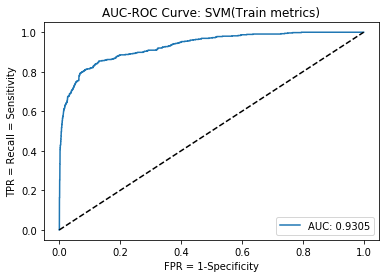

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.914  |
|      F1-score     | 0.6387 |
|     Precision     | 0.8085 |
|       Recall      | 0.5278 |
|    Specificity    | 0.979  |
|        MCC        | 0.6097 |
|    AUROC value    | 0.8784 |
+-------------------+--------+


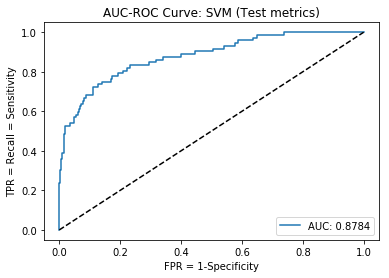

--------------------------------------------------------------





In [10]:
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
param_grid = {'C': Cs}
linear_svm = GridSearchCV(SVC(kernel='linear',probability=True), param_grid, cv=5)
linear_svm.fit(X_train,y_train)


linear_svm_train_pred, linear_svm_test_pred = linear_svm.predict(X_train), linear_svm.predict(X_test)
linear_svm_train_scores, linear_svm_test_scores = linear_svm.predict_proba(X_train)[:,1], linear_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=Linear) classifier')
linear_svm_metric_list_train, linear_metric_list_test = metric(y_train, linear_svm_train_pred, linear_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, linear_svm_test_pred, linear_svm_test_scores, 'SVM (Test metrics)')

#### kernel=poly

SVM(kernel=Poly) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9444 |
|      F1-score     | 0.7289 |
|     Precision     | 0.9057 |
|       Recall      | 0.6098 |
|    Specificity    | 0.9911 |
|        MCC        | 0.7162 |
|    AUROC value    | 0.9489 |
+-------------------+--------+


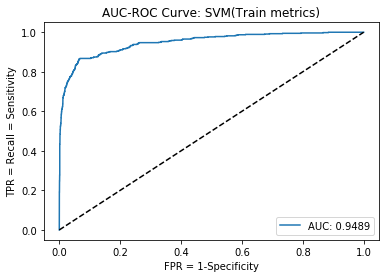

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.906  |
|      F1-score     | 0.5983 |
|     Precision     | 0.7778 |
|       Recall      | 0.4861 |
|    Specificity    | 0.9766 |
|        MCC        | 0.5677 |
|    AUROC value    | 0.883  |
+-------------------+--------+


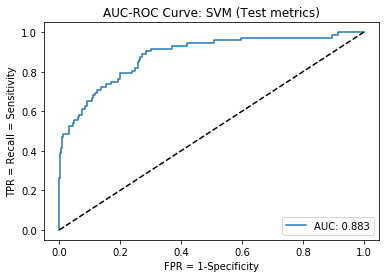

--------------------------------------------------------------





In [11]:
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
poly_svm = GridSearchCV(SVC(kernel='poly',probability=True), param_grid, cv=5)
poly_svm.fit(X_train,y_train)

poly_svm_train_pred, poly_svm_test_pred = poly_svm.predict(X_train), poly_svm.predict(X_test)
poly_svm_train_scores, poly_svm_test_scores = poly_svm.predict_proba(X_train)[:,1], poly_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=Poly) classifier')
poly_svm_metric_list_train, poly_svm_metric_list_test = metric(y_train, poly_svm_train_pred, poly_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, poly_svm_test_pred, poly_svm_test_scores, 'SVM (Test metrics)')

#### kernel=rbf

SVM(kernel=RBF) classifier
+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.9458 |
|      F1-score     | 0.7371 |
|     Precision     | 0.9072 |
|       Recall      | 0.6207 |
|    Specificity    | 0.9911 |
|        MCC        | 0.7239 |
|    AUROC value    | 0.9526 |
+-------------------+--------+


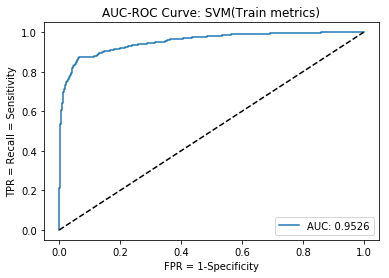

--------------------------------------------------------------



+-------------------+--------+
| Evaluation Metric | Score  |
+-------------------+--------+
|      Accuracy     | 0.904  |
|      F1-score     | 0.5932 |
|     Precision     | 0.7609 |
|       Recall      | 0.4861 |
|    Specificity    | 0.9743 |
|        MCC        | 0.5593 |
|    AUROC value    | 0.8825 |
+-------------------+--------+


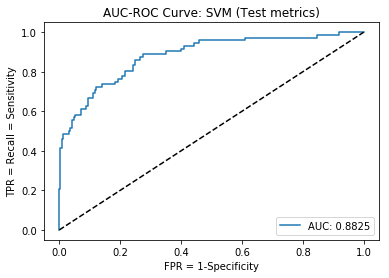

--------------------------------------------------------------





In [12]:
Cs = [0.001, 0.01, 0.1, 1, 10,100,1000]
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
rbf_svm = GridSearchCV(SVC(kernel='rbf',probability=True), param_grid, cv=5)
rbf_svm.fit(X_train,y_train)

rbf_svm_train_pred, rbf_svm_test_pred = rbf_svm.predict(X_train), rbf_svm.predict(X_test)
rbf_svm_train_scores, rbf_svm_test_scores = rbf_svm.predict_proba(X_train)[:,1], rbf_svm.predict_proba(X_test)[:,1]


print('SVM(kernel=RBF) classifier')
rbf_svm_metric_list_train, rbf_svm_metric_list_test = metric(y_train, rbf_svm_train_pred, rbf_svm_train_scores, 'SVM(Train metrics)'),\
                                                        metric(y_test, rbf_svm_test_pred, rbf_svm_test_scores, 'SVM (Test metrics)')